In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

# sklearn digits dataset

Images are 8x8 pixels.

## Load data

In [2]:
from sklearn.datasets import load_digits

# Load the digits dataset
digits = load_digits()
print( dir(digits) )

['DESCR', 'data', 'feature_names', 'frame', 'images', 'target', 'target_names']


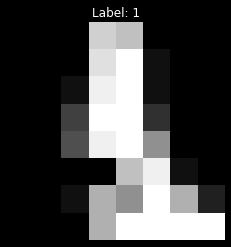

In [3]:
# Pick a random index
idx = np.random.randint(0, len(digits.images))

# Display the image
plt.figure(figsize=(4, 4))
plt.imshow(digits.images[idx], cmap='gray')
plt.title(f"Label: {digits.target[idx]}")
plt.axis('off')
plt.show()

## Create/train/analyze model

In [4]:
X = digits.data
y = digits.target

print(X.shape)

(1797, 64)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y
)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

dropout_rate = 0.1

n_features = X.shape[1]
n_classes  = np.unique(y).shape[0]

# Create model
model = Sequential([
    Input(shape=n_features),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Dense(8, activation='relu'),
    
    Dense(n_classes, activation='softmax'),
])

# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.01)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=25,          # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)
# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                2080      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 16)                0

In [7]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100
23/23 [==============================] - 1s 8ms/step - loss: 1.6946 - accuracy: 0.4349 - val_loss: 1.4767 - val_accuracy: 0.5167
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.7590 - accuracy: 0.7704 - val_loss: 2.5441 - val_accuracy: 0.5333
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.3862 - accuracy: 0.8866 - val_loss: 1.5798 - val_accuracy: 0.6389
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2769 - accuracy: 0.9102 - val_loss: 0.9217 - val_accuracy: 0.7778
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2219 - accuracy: 0.9381 - val_loss: 0.4334 - val_accuracy: 0.8306
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2148 - accuracy: 0.9283 - val_loss: 0.3954 - val_accuracy: 0.8861
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.1498 - accuracy: 0.9450 - val_loss: 0.2258 - val_accuracy: 0.9250
Epoch 8/100
2

12/12 [==============================] - 0s 544us/step


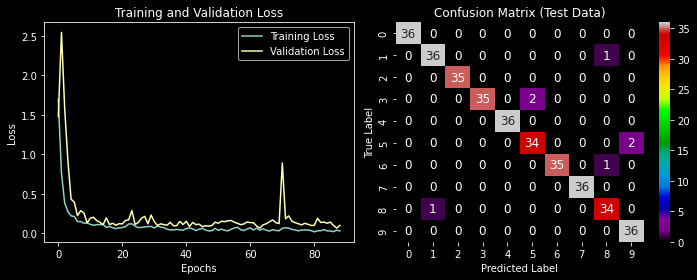

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.97      0.97      0.97        37
           2       1.00      1.00      1.00        35
           3       1.00      0.95      0.97        37
           4       1.00      1.00      1.00        36
           5       0.94      0.94      0.94        36
           6       1.00      0.97      0.99        36
           7       1.00      1.00      1.00        36
           8       0.94      0.97      0.96        35
           9       0.95      1.00      0.97        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



In [8]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_train_pred = model.predict(X_train).argmax(axis=1)
y_test_pred  = model.predict(X_test).argmax(axis=1)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left subplot: Training and Validation Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
#axes[0].set_yscale('log')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Right subplot: Confusion Matrix (Test Data) using seaborn heatmap with vmin set to 0
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1], vmin=0, 
            annot_kws={"size": 12}, cmap='nipy_spectral')
axes[1].set_title('Confusion Matrix (Test Data)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Print classification report for test data
report = classification_report(y_test, y_test_pred)
print(report)

# Keras MNIST dataset

Images are 28x28 pixels.

## Load data

In [9]:
from tensorflow.keras.datasets import mnist

# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Print shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)

X_train.shape: (60000, 28, 28)
X_test.shape:  (10000, 28, 28)


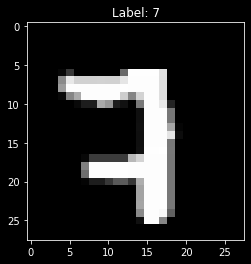

In [10]:
# Display a random image
idx = np.random.randint(0, len(X_train))
plt.figure(figsize=(4, 4))
plt.imshow(X_train[idx], cmap='gray')
plt.title(f"Label: {y_train[idx]}")
plt.show()

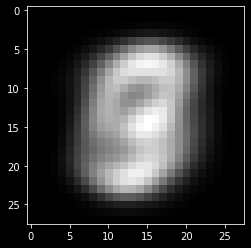

In [11]:
plt.imshow( X_train.mean(axis=0), cmap='gray' )

## Create/train/analyze model

In [12]:
# flatten images into vectors
X_train_flat = X_train.reshape(X_train.shape[0],-1)
X_test_flat  = X_test.reshape(X_test.shape[0],-1)

print("X_train_flat.shape:", X_train_flat.shape)
print("X_test_flat.shape: ", X_test_flat.shape)

X_train_flat.shape: (60000, 784)
X_test_flat.shape:  (10000, 784)


In [13]:
dropout_rate = 0.1

n_features = X_train_flat.shape[1]
n_classes  = np.unique(y_train).shape[0]

# Create model
model = Sequential([
    Input(shape=n_features),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Dense(8, activation='relu'),
    
    Dense(n_classes, activation='softmax'),
])

# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.01)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=25,          # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                25120     
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization_3 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 16)               

In [14]:
history = model.fit(
    X_train_flat, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test_flat, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
938/938 [==============================] - 2s 1ms/step - loss: 0.4405 - accuracy: 0.8684 - val_loss: 0.2193 - val_accuracy: 0.9350
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 0.2806 - accuracy: 0.9180 - val_loss: 0.1759 - val_accuracy: 0.9470
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 0.2406 - accuracy: 0.9301 - val_loss: 0.1573 - val_accuracy: 0.9522
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 0.2248 - accuracy: 0.9344 - val_loss: 0.1470 - val_accuracy: 0.9569
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 0.2141 - accuracy: 0.9367 - val_loss: 0.1527 - val_accuracy: 0.9561
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 0.1988 - accuracy: 0.9417 - val_loss: 0.1416 - val_accuracy: 0.9584
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 0.1885 - accuracy: 0.9444 - val_loss: 0.1469 - val_accuracy: 0.9584
Epoch 

313/313 [==============================] - 0s 572us/step


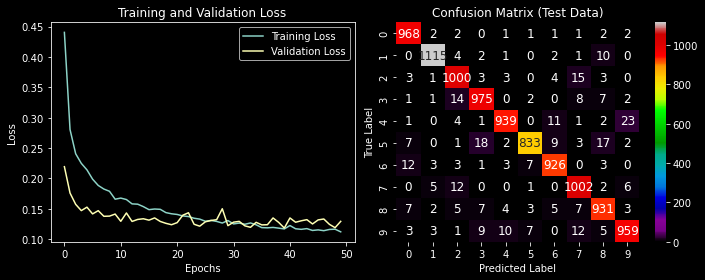

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.96      0.97       982
           5       0.98      0.93      0.95       892
           6       0.97      0.97      0.97       958
           7       0.95      0.97      0.96      1028
           8       0.95      0.96      0.95       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_train_pred = model.predict(X_train_flat).argmax(axis=1)
y_test_pred  = model.predict(X_test_flat).argmax(axis=1)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left subplot: Training and Validation Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
#axes[0].set_yscale('log')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Right subplot: Confusion Matrix (Test Data) using seaborn heatmap with vmin set to 0
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1], vmin=0, 
            annot_kws={"size": 12}, cmap='nipy_spectral')
axes[1].set_title('Confusion Matrix (Test Data)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Print classification report for test data
report = classification_report(y_test, y_test_pred)
print(report)

## Predict an augmented image

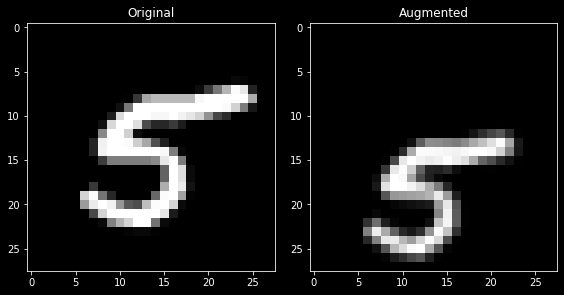

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image generator with augmentation options
datagen = ImageDataGenerator(
    rotation_range=30,      # Rotate images randomly
    width_shift_range=0.2,  # Randomly shift the width of images
    height_shift_range=0.2, # Randomly shift the height of images
    zoom_range=0.2,         # Randomly zoom
    shear_range=0.1         # Apply shear transformation
)

idx = np.random.randint(0, len(X_test))

image_orig = X_test[idx]

image_aug = datagen.flow(
    image_orig[np.newaxis,:,:,np.newaxis],
    batch_size=1,
    shuffle=False
).next()[0,:,:,0]

# Plot original and augmented image
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(image_orig, cmap='gray')
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(image_aug, cmap='gray')
plt.title("Augmented")

plt.tight_layout()
plt.show()

In [17]:
# Ensure image shape is (1, 28, 28, 1) and type is float32
image_orig_input = image_orig.flatten()[np.newaxis, :]
image_aug_input  = image_aug.flatten()[np.newaxis, :]

# Predict using the model
pred_orig = model.predict(image_orig_input)
pred_aug = model.predict(image_aug_input)

# Get predicted digit (argmax of class probabilities)
digit_orig = np.argmax(pred_orig)
digit_aug = np.argmax(pred_aug)

print(f"Original image prediction:  {digit_orig}")
print(f"Augmented image prediction: {digit_aug}")

1/1 [==============================] - 0s 55ms/step
Original image prediction:  5
Augmented image prediction: 6


Since only the center pixels ever have ink in them where the letters are drawn, the weights corresponding to the outer pixels don't ever get and information to train on other than 0's. This means that images which are different in scale, translation, or rotation will not be accurately predicted.

# Keras MNIST w/ augmented images

## Create augmented dataset

In [18]:
from tensorflow.keras.datasets import mnist

# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Print shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)

X_train.shape: (60000, 28, 28)
X_test.shape:  (10000, 28, 28)


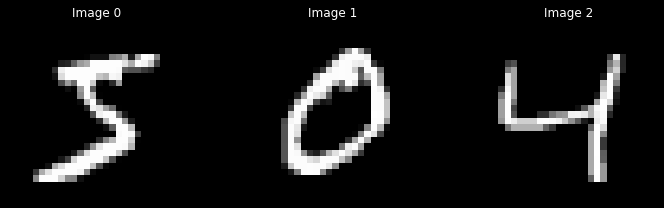

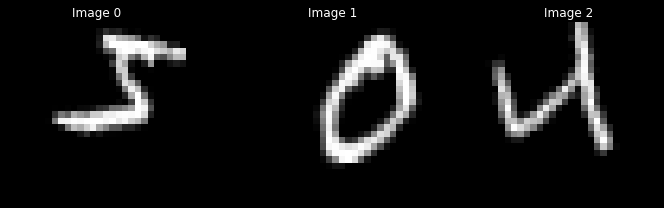

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image generator with augmentation options
datagen = ImageDataGenerator(
    rotation_range=30,      # Rotate images randomly
    width_shift_range=0.2,  # Randomly shift the width of images
    height_shift_range=0.2, # Randomly shift the height of images
    zoom_range=0.2,         # Randomly zoom
    shear_range=0.1         # Apply shear transformation
)

# Plot the first 3 images
plt.figure(figsize=(10, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Image {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

X_train = datagen.flow(
    X_train[:,:,:,np.newaxis],
    batch_size=X_train.shape[0],
    shuffle=False
).next()[:,:,:,0]

# Plot the first 3 images
plt.figure(figsize=(10, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Image {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

X_test = datagen.flow(
    X_test[:,:,:,np.newaxis],
    batch_size=X_test.shape[0],
    shuffle=False
).next()[:,:,:,0]

## Create/train/analyze model

In [20]:
# flatten images into vectors
X_train_flat = X_train.reshape(X_train.shape[0],-1)
X_test_flat  = X_test.reshape(X_test.shape[0],-1)

print("X_train_flat.shape:", X_train_flat.shape)
print("X_test_flat.shape: ", X_test_flat.shape)

X_train_flat.shape: (60000, 784)
X_test_flat.shape:  (10000, 784)


In [21]:
dropout_rate = 0.1

n_features = X_train_flat.shape[1]
n_classes  = np.unique(y_train).shape[0]

# Create model
model = Sequential([
    Input(shape=n_features),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Dense(8, activation='relu'),
    
    Dense(n_classes, activation='softmax'),
])

# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.01)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

# Display model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                25120     
                                                                 
 batch_normalization_4 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 32)               

In [22]:
history = model.fit(
    X_train_flat, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test_flat, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
938/938 [==============================] - 2s 1ms/step - loss: 1.6376 - accuracy: 0.4190 - val_loss: 1.2108 - val_accuracy: 0.5835
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 1.3592 - accuracy: 0.5287 - val_loss: 1.0808 - val_accuracy: 0.6443
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 1.2681 - accuracy: 0.5638 - val_loss: 0.9909 - val_accuracy: 0.6692
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 1.2207 - accuracy: 0.5836 - val_loss: 0.9345 - val_accuracy: 0.6827
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 1.1777 - accuracy: 0.5976 - val_loss: 0.8956 - val_accuracy: 0.7039
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 1.1590 - accuracy: 0.6089 - val_loss: 0.8843 - val_accuracy: 0.7137
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.1395 - accuracy: 0.6162 - val_loss: 0.8375 - val_accuracy: 0.7254
Epoch 

313/313 [==============================] - 0s 566us/step


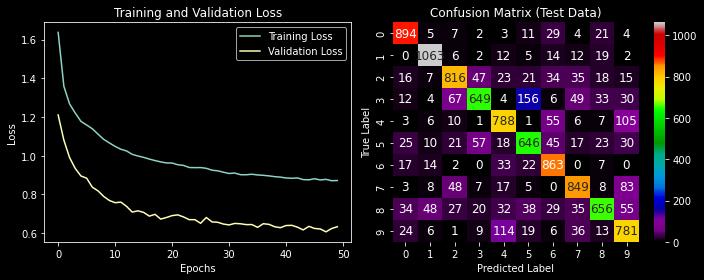

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       980
           1       0.91      0.94      0.92      1135
           2       0.81      0.79      0.80      1032
           3       0.82      0.64      0.72      1010
           4       0.75      0.80      0.78       982
           5       0.70      0.72      0.71       892
           6       0.80      0.90      0.85       958
           7       0.81      0.83      0.82      1028
           8       0.81      0.67      0.74       974
           9       0.71      0.77      0.74      1009

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_train_pred = model.predict(X_train_flat).argmax(axis=1)
y_test_pred  = model.predict(X_test_flat).argmax(axis=1)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left subplot: Training and Validation Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
#axes[0].set_yscale('log')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Right subplot: Confusion Matrix (Test Data) using seaborn heatmap with vmin set to 0
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1], vmin=0, 
            annot_kws={"size": 12}, cmap='nipy_spectral')
axes[1].set_title('Confusion Matrix (Test Data)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Print classification report for test data
report = classification_report(y_test, y_test_pred)
print(report)